In [1]:
!git clone https://github.com/ai-forever/ru-clip.git

Cloning into 'ru-clip'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 229 (delta 61), reused 44 (delta 38), pack-reused 127 (from 1)
Receiving objects: 100% (229/229), 6.50 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [2]:
!pip install youtokentome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for youtokentome: filename=youtokentome-1.0.6-cp310-cp310-linux_x86_64.whl size=1951579 sha256=b69f048993abc55e6d3437b192f865c95d09ab84535149223e2481fc7873ce31
  Stored in directory: /root/.cache/pip/wheels/df/85/f8/301d2ba45f43f30bed2fe413efa760bc726b8b660ed9c2900c
Successfully built youtokentome


In [3]:
import os
os.rename('/content/ru-clip', '/content/ruclip')

import torch
import requests
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from ruclip import ruclip
from glob import glob
from tqdm import tqdm

In [10]:
#load model
device = 'cuda' # <--!!!
all_models = [
    'ruclip-vit-base-patch32-224',
    'ruclip-vit-base-patch16-224',
    'ruclip-vit-large-patch14-224',
    'ruclip-vit-large-patch14-336',
    'ruclip-vit-base-patch32-384',
    'ruclip-vit-base-patch16-384'
]
clip, processor = ruclip.load(
    "ruclip-vit-base-patch16-224",
    device=device,
    cache_dir='/content/ruclip',
    use_auth_token=False
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:680: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


bpe.model:   0%|          | 0.00/748k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

/content/ruclip/ruclip/model.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(folder, 'pytorch_model.bin'), map_location='cpu')


In [12]:
def load_image_list(path):
  images = []
  for path in tqdm(glob(f'path/*')):
    images.append(Image.open(path))
  return images

train_images = load_image_list('train/images')
val_images = load_image_list('val/images')

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [13]:
def make_preds(images, classes, templates, predictor):
  with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    pred_labels = predictor.run(images, text_latents)
  return pred_labels

def get_embeds(images, classes, templates, predictor):
  with torch.no_grad():
    embeds = predictor.get_image_latents(images).cpu().numpy()
  return embeds

In [14]:
def visualize_pil_images(images, txts):
  plt.ioff()
  f, ax = plt.subplots(2,4, figsize=(12,6))
  for i, (pil_img, txt) in enumerate(zip(images, txts)):
      ax[i//4, i%4].imshow(pil_img)
      ax[i//4, i%4].set_title(txt)
  f.tight_layout()
  plt.show()

In [15]:
def demo_images():
  import requests
  import base64
  from io import BytesIO

  bs4_urls = requests.get('https://raw.githubusercontent.com/ai-forever/ru-dolph/master/pics/pipelines/cats_vs_dogs_bs4.json').json()
  images = [Image.open(BytesIO(base64.b64decode(bs4_url))) for bs4_url in bs4_urls]
  return images

classes = ['кошка', 'собака']
templates = ['{}', 'это {}', 'на картинке {}', 'это {}, домашнее животное']
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)
preds = make_preds(demo_images(), classes, templates, predictor)

8it [00:00, 10.55it/s]


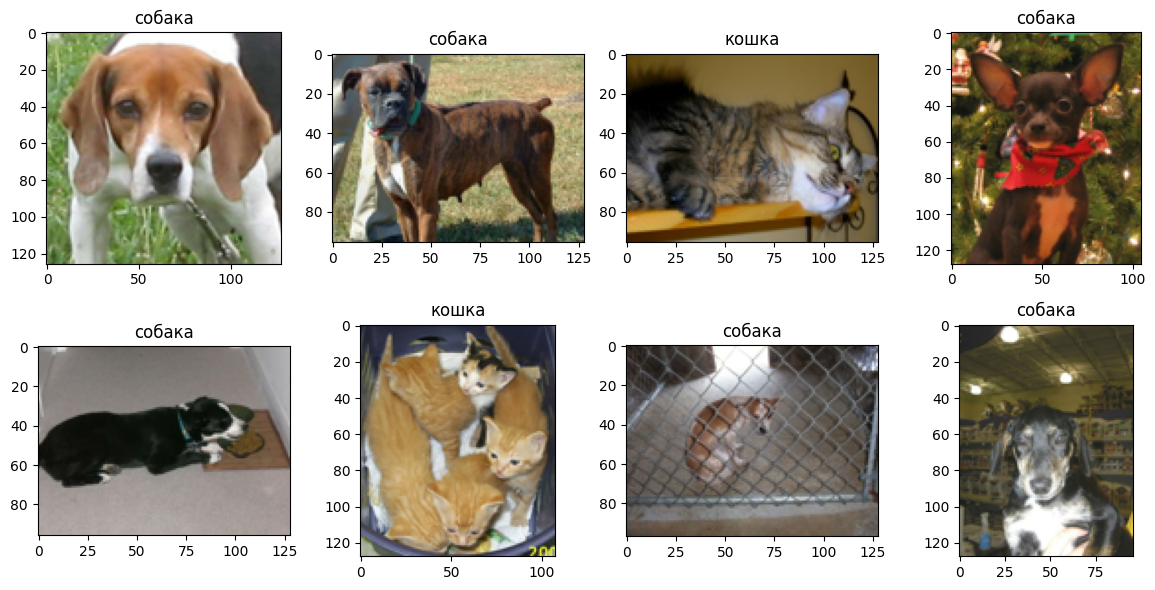

In [49]:
if vis := True:
  visualize_pil_images(demo_images(), [classes[pr] for pr in preds])

In [16]:
embeds = get_embeds(demo_images(), classes, templates, predictor)
embeds.shape

8it [00:00, 248.48it/s]


(8, 512)

In [51]:
def save_embeds(embeds, path):
  import pickle
  with open(path, 'wb') as f:
    pickle.dump(embeds, f)

def load_embeds(path):
  import pickle
  with open(path, 'rb') as f:
    d = pickle.load(f)
  return d

embeds_path = '/content/demo_embeds.pickle'
save_embeds(embeds, embeds_path)
embeds = load_embeds(embeds_path)

In [52]:
#fit simple model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, verbose=1)
clf.fit(embeds, preds)

y_pred = clf.predict(embeds)

print((y_pred == preds).sum() / 8)

0.75


In [40]:
[classes.index(cl) for cl in classes]

[0, 1]

In [ ]:
#making sub